In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Resizing, Rescaling

In [47]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=5
FINE_TUNE_POINT = 125
LEARNING_RATE = 0.001

In [22]:
dataset = image_dataset_from_directory(
    'Potato',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [23]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [24]:
len(dataset)

68

In [25]:
for img_batch, lab_batch in dataset.take(1):
  print(img_batch.shape)
  print(lab_batch.numpy())

(32, 128, 128, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


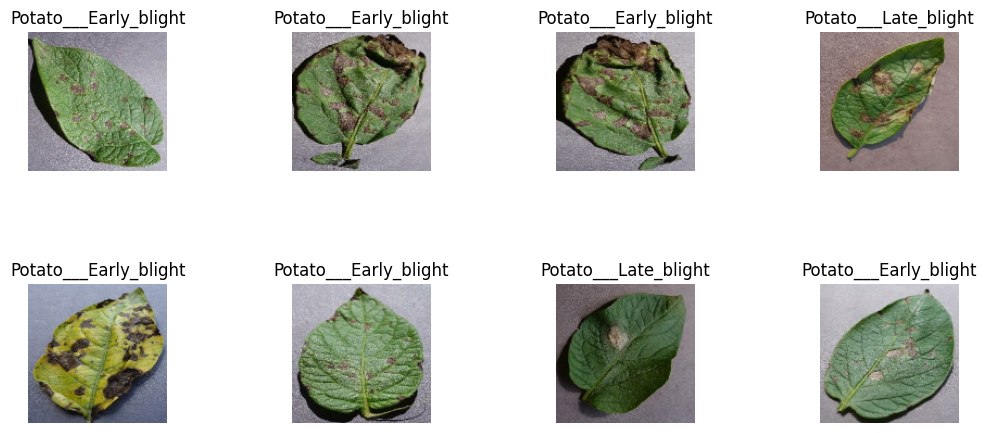

In [26]:
plt.figure(figsize=(12,6))
for img_batch, lab_batch in dataset.take(1):
  for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    plt.imshow(img_batch[i].numpy().astype('uint8'))
    plt.title(class_names[lab_batch[i]])
    plt.axis('off')
    plt.subplots_adjust(wspace=0.9, hspace=0.2)

In [27]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [29]:
len(train_ds)

54

In [30]:
len(val_ds)

6

In [31]:
len(test_ds)

8

In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
resize_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255),])

In [34]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),])

In [35]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load Base Model

In [37]:
INPUT_SHAPE = (IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
weights_path = 'mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5'
base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights=weights_path
)
base_model.trainable = True

print(len(base_model.layers))

154


In [39]:
for layer in base_model.layers[:FINE_TUNE_POINT]:
    layer.trainable = False

# Create the Model

In [44]:
model = tf.keras.models.Sequential([
    resize_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax'),
])
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS))

In [45]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (32, 1280)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_3 (Flatten)         (32, 1280)                0         
                                                                 
 dense_6 (Dense)             (32, 64)                  81984     
                                                                 
 dropout_3 (Dropout)         (32, 64)                 

In [49]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)